## Description

In this project , I implemented a vision transformer (ViT) in PyTorch. 

Reference:

[1] Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S. and Uszkoreit, J., 2020. An image is worth 16x16 words: Transformers for image recognition at scale. ICLR 2021. https://arxiv.org/abs/2010.11929


<img src="https://drive.google.com/uc?export=view&id=1TLwPc2Bo1HIowpQNqeVGTUZwtc3LPPiE" width="600em"/>

My implementation has a "patchify" function to divide the input image into patches.  It patchifies a 28x28 MNIST image into 7 pixel by 7 pixel patches. So, in the end, an image yields 16 patches, because there will be 4 patch rows and 4 patch columns. Each patch is flattened to a 49-dimensional vector (49 because each patch is 7x7 pixels).

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

D = 64
HEAD_NUM = 6
BIAS = False


In [2]:
class MultiHeadSelfAttention(nn.Module):
  def __init__(self):
    super().__init__()
    self.head_num = HEAD_NUM
    self.embedding_dim = 8+D
    self.head_len = self.embedding_dim // self.head_num   #72 / 6 = 12

    self.Wq = nn.Linear(self.embedding_dim,self.embedding_dim, bias=BIAS)
    self.Wk = nn.Linear(self.embedding_dim,self.embedding_dim, bias=BIAS)
    self.Wv = nn.Linear(self.embedding_dim,self.embedding_dim, bias=BIAS)

  def _scaled_dot_product(self,Q,K):
    # (batch_size x head number x patch number x head length)
    Q = Q.permute(0,2,1,3)
    #print("Q shape after permute:", Q.shape)
    # (batch_size x head number x head length x patch number)
    K = K.permute(0,2,3,1)
    #print("K shape after permute:", K.shape)
    # (batch_size x head number x patch number x patch number)
    dot_product = torch.matmul(Q,K)

    scale_factor = math.sqrt(self.head_len)

    return dot_product/scale_factor


  def forward(self, x):

    batch_size,patch_num,_ = x.shape

    # (batch_size x patch number x head number x head length)
    Q = (self.Wq(x)).view(batch_size,patch_num,self.head_num,self.head_len)
    K = (self.Wk(x)).view(batch_size,patch_num,self.head_num,self.head_len)
    V = (self.Wv(x)).view(batch_size,patch_num,self.head_num,self.head_len)
    #print("Q,K,V shapes:", Q.shape)

    # (batch_size x head number x patch number x head length)
    V = V.permute(0,2,1,3)
    #print("V shape:", V.shape)

    # (QK^{T})/ sqrt(dk)
    # (batch_size x head number x patch number x patch number)
    scaled_dot_product = self._scaled_dot_product(Q,K)

    # softmax((QK^{T})/ sqrt(dk))
    attention_weights = torch.softmax(scaled_dot_product, dim=-1)
    #print("attention_weights shape:", attention_weights.shape)

    out = torch.matmul(attention_weights,V)

    # (batch_size x patch number x head number x head length)
    out = out.permute(0,2,1,3)
    out = out.contiguous()

    # (batch_size x patch number x (8+D))
    out = out.view(-1,patch_num,self.embedding_dim)

    return out


In [3]:
class TransformerEncoder(nn.Module):
  def __init__(self):
    super().__init__()

    self.embedding_size = 8+D

    self.attention = MultiHeadSelfAttention()

    self.mlp = nn.Sequential(
        nn.LayerNorm(self.embedding_size),
        nn.Linear(self.embedding_size, 2 * self.embedding_size),
        nn.ReLU(),
        nn.Linear(2 * self.embedding_size, self.embedding_size)
    )

    self.norm = nn.LayerNorm(self.embedding_size)

  def forward(self, x):
    normalized_embeddings = self.norm(x)
    attention = self.attention(normalized_embeddings)
    #Skip connection
    x = attention + x

    mlp_out = self.mlp(x)
    #Skip connection
    out = mlp_out + x

    return out


In [4]:
class ViT(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear_projection = nn.Linear(49, D)
    self.positional_encodings = self.create_positional_encodings()

    self.transformer_encoder = TransformerEncoder()

    self.mlp_head = nn.Linear((D+8),10)

  def patchify(self, images):
    N,_,_,_ = images.shape
    patched_images = images.unfold(2, 7, 7)
    patched_images = patched_images.unfold(3, 7, 7)
    patched_images = patched_images.contiguous()
    patched_images = patched_images.view(N, 16, -1)

    return patched_images

  def create_positional_encodings(self):
    rows = torch.zeros(16, 4)
    columns = torch.zeros(16, 4)

    encodings = torch.zeros(16, 8)

    for i in range(16):
      row = i // 4
      column = i % 4
      rows[i, row] = 1
      columns[i, column] = 1
      encodings[i][:4] = rows[i]
      encodings[i][4:] = columns[i]

    return encodings


  def forward(self, x):
    N,_,_,_ = x.shape

    patches = self.patchify(x)

    linearized_patches = self.linear_projection(patches)
    #print(f"linearized patches shape: {linearized_patches.shape}")

    tokens = torch.cat((self.positional_encodings.expand(N,-1,-1), linearized_patches),dim=2)
    #print(f"tokens shape: {tokens.shape}")

    encoder_out = self.transformer_encoder(tokens)
    first_patches = encoder_out[:,0,:]
    logits = self.mlp_head(first_patches)
    return logits


In [ ]:
#####TEST#####
"""
attention = MultiHeadSelfAttention()

batch_size = 256
patch_num = 16
embedding_dim = 8 + D

query = torch.randn(batch_size, patch_num, embedding_dim)
key = torch.randn(batch_size, patch_num, embedding_dim)
value = torch.randn(batch_size, patch_num, embedding_dim)
print("Query shape:", query.shape)

output = attention(query, key, value)

print("Output shape:", output.shape)
"""

Query shape: torch.Size([256, 16, 72])
Q,K,V shapes: torch.Size([256, 16, 6, 12])
V shape: torch.Size([256, 6, 16, 12])
Q shape after permute: torch.Size([256, 6, 16, 12])
K shape after permute: torch.Size([256, 6, 12, 16])
attention_weights shape: torch.Size([256, 6, 16, 16])
Output shape: torch.Size([256, 16, 72])


torch.Size([64, 1, 28, 28])
torch.Size([64, 16, 49])
linearized patches shape: torch.Size([64, 16, 64])
tokens shape: torch.Size([64, 16, 72])
tensor([[1., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 1.]])
tensor([ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,
        -0.5634,  0.0709, -0.6953,  0.0025,  0.8252, -0.0052, -0.7264,  0.4956,
         1.0031, -0.2655

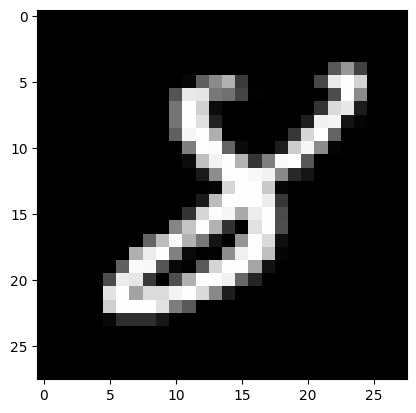

torch.Size([256, 1, 28, 28])


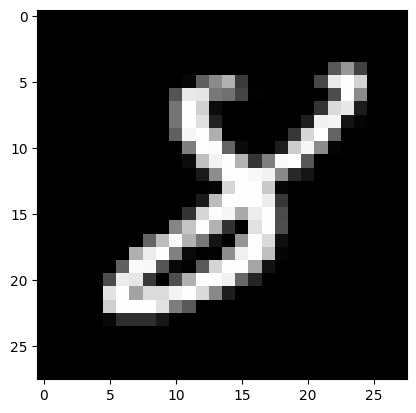

torch.Size([256, 16, 49])


In [ ]:
"""
#####TEST#####
import matplotlib.pyplot as plt

def reconstruct_and_display(patches, index):
    reconstructed = patches[index].view(4, 4, 7, 7).permute(0, 2, 1, 3).contiguous().view(28, 28)
    plt.imshow(reconstructed, cmap='gray')
    plt.show()

batch_size = 64
images = torch.randn(batch_size, 1, 28, 28)
#MNIST is a Nx1x28x28 tensor
print(images.shape)
vit_model = ViT()
"""




"""
patches = vit_model.patchify(images)
#Nx16x49
print(patches.shape)

tokens = vit_model.forward(images)

print(vit_model.positional_encodings)

print(tokens[0][2])
"""

"""
dataset = datasets.MNIST(root='./../datasets', train=False, download=True, transform=transforms.ToTensor())
data_loader = DataLoader(dataset, shuffle=True, batch_size=256)
for it, batch in enumerate(data_loader):
    x, y = batch
    vit_model = ViT()
    plt.imshow(x[0].squeeze(0), cmap='gray')
    plt.show()
    print(x.shape)
    patches = vit_model.patchify(x)
    reconstruct_and_display(patches,0)
    print(patches.shape)
    break
"""

In [5]:
# Loading data
dataset = datasets.MNIST(root='./../datasets', train=False, download=True, transform=transforms.ToTensor())
data_loader = DataLoader(dataset, shuffle=True, batch_size=256)

# Defining model and training options
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViT()

num_epochs = 2
lr = 0.005

100%|██████████| 9912422/9912422 [00:00<00:00, 89035035.72it/s]


Extracting ./../datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./../datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 9907229.40it/s]


Extracting ./../datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./../datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23892968.45it/s]


Extracting ./../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./../datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5248079.55it/s]


Extracting ./../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./../datasets/MNIST/raw



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
Epoch 1/2 loss: 1.17
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
Epoch 2/2 loss: 0.43


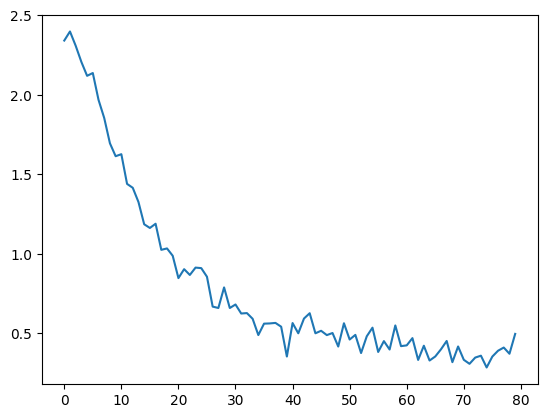

In [6]:
# Training loop
optimizer = Adam(model.parameters(), lr=lr)
criterion = CrossEntropyLoss()
losses = []
for epoch in range(num_epochs):
    train_loss = 0.0
    for it, batch in enumerate(data_loader):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        loss_val = loss.detach().cpu().item()
        train_loss += loss_val / len(data_loader)
        losses.append(loss_val)

        print(it)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs} loss: {train_loss:.2f}")

from matplotlib import pyplot as plt
plt.plot(losses)
plt.show()